<a href="https://colab.research.google.com/github/NGC55/work/blob/main/imagematting_indexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/NGC55/indexnet_matting_sample.git

Cloning into 'indexnet_matting_sample'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 103 (delta 11), reused 103 (delta 11), pack-reused 0
Receiving objects: 100% (103/103), 43.01 MiB | 9.50 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [3]:
%cd /content/indexnet_matting_sample

/content/indexnet_matting_sample


In [4]:
!pwd

/content/indexnet_matting_sample


In [5]:
!python /content/indexnet_matting_sample/scripts/demo.py

framerate: 7.83Hz
framerate: 1.63Hz
framerate: 74.98Hz
framerate: 64.17Hz
framerate: 73.01Hz


# import

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms

# サンプルを確認

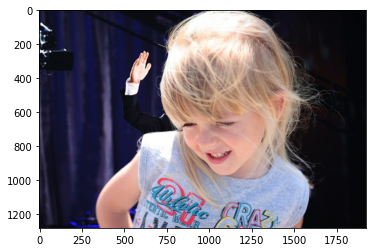

In [7]:
img = cv2.imread("/content/indexnet_matting_sample/examples/images/boy-1518482_1920_9.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# matting

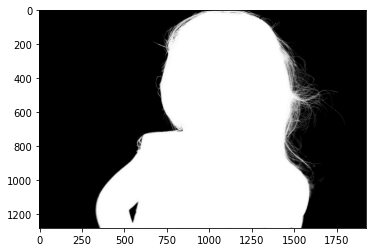

In [8]:
matte = cv2.imread("/content/indexnet_matting_sample/examples/mattes/boy-1518482_1920_9.png")
matte = cv2.cvtColor(matte, cv2.COLOR_BGR2RGB)
plt.imshow(matte)

# trimap

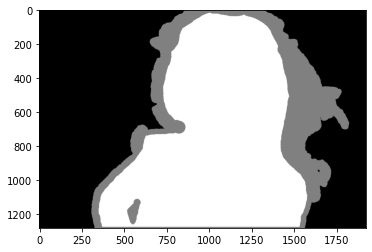

In [9]:
tri = cv2.imread("/content/indexnet_matting_sample/examples/trimaps/boy-1518482_1920_9.png")
tri = cv2.cvtColor(tri, cv2.COLOR_BGR2RGB)
plt.imshow(tri)

In [10]:
h,w,_ = img.shape
bg = np.full_like(img,255) #white background

# 背景除去

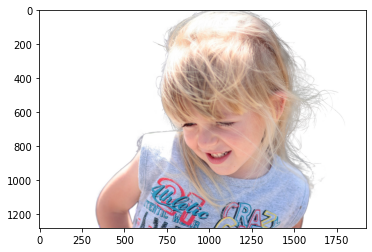

In [11]:
img = img.astype(float)
bg = bg.astype(float)

matte = matte.astype(float)/255
img = cv2.multiply(img, matte)
bg = cv2.multiply(bg, 1.0 - matte)
outImage = cv2.add(img, bg)
plt.imshow(outImage/255)

# deeplabv3_resnet101でtrimapを作成

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# create model for segmentation
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.to(device)
model.eval();

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [13]:
# read image
org_path ="/content/drive/MyDrive/work/canon-rf85mm-f-2-macro-is-stm-portrait-photography_2063-02.JPG"
img_path = "/content/indexnet_matting_sample/examples/images/image01.png"

img = cv2.imread(org_path)
cv2.imwrite(img_path, img, [int(cv2.IMWRITE_PNG_COMPRESSION ), 1])
#cv2.imwrite(img_path,img)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h,w,_ = img.shape
img = cv2.resize(img,(320,320)) # Deepl3の入力サイズに合わせてリサイズ
print(h,w)

816 544


In [14]:
# tensorに変換
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0).to(device)

## make mask

torch.Size([21, 320, 320])
(320, 320)
h:816, w:544


<Figure size 432x288 with 0 Axes>

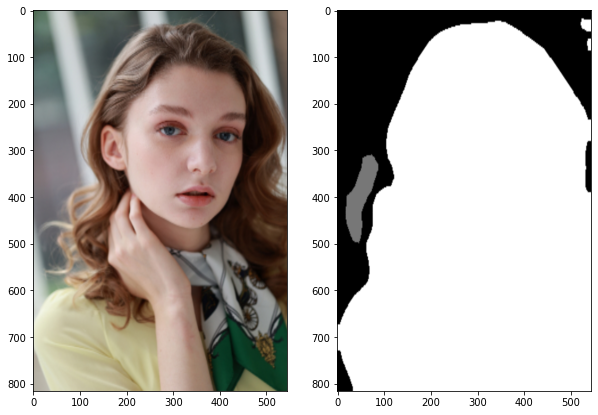

In [15]:
with torch.no_grad():
    outputs = model(input_batch)['out'][0]
    print(outputs.shape)
output = outputs.argmax(0)

mask = output.byte().cpu().numpy()
print(mask.shape)
mask = cv2.resize(mask,(w,h))
img = cv2.resize(img,(w,h))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.gray()
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask);

print(f"h:{h}, w:{w}")

In [16]:
outputs[0]

tensor([[7.4531, 7.4531, 7.4531,  ..., 6.5978, 6.5978, 6.5978],
        [7.4531, 7.4531, 7.4531,  ..., 6.5978, 6.5978, 6.5978],
        [7.4531, 7.4531, 7.4531,  ..., 6.5978, 6.5978, 6.5978],
        ...,
        [6.1414, 6.1414, 6.1414,  ..., 5.0451, 5.0451, 5.0451],
        [6.1414, 6.1414, 6.1414,  ..., 5.0451, 5.0451, 5.0451],
        [6.1414, 6.1414, 6.1414,  ..., 5.0451, 5.0451, 5.0451]],
       device='cuda:0')

1331712


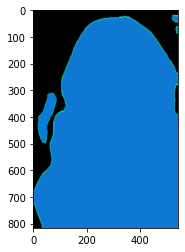

In [17]:
from PIL import Image

# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

input_image = Image.open(img_path)

# plot the semantic segmentation predictions of 21 classes in each color
out = output.byte().cpu().numpy()
r = Image.fromarray(out)
print(img.size)
r = r.resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)

## make trimap

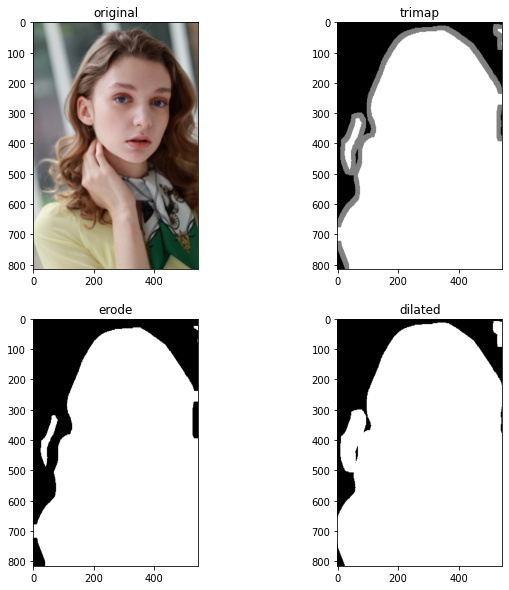

In [18]:
# マスク画像をerodeとdilateしてtrimapを作成
def gen_trimap(mask,k_size=(10,10),ite=1):
    kernel = np.ones(k_size,np.uint8)
    eroded = cv2.erode(mask,kernel,iterations = ite)
    dilated = cv2.dilate(mask,kernel,iterations = ite)
    trimap = np.full((h,w), 128,  dtype=np.uint8)
    trimap[eroded == 255] = 255
    trimap[dilated == 0] = 0
    return trimap, eroded, dilated

np.place(mask, mask >0 , 255)
trimap, eroded, dilated = gen_trimap(mask,k_size=(15,15),ite=1)

cv2.imwrite('/content/indexnet_matting_sample/examples/trimaps/trimap.png',trimap)
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title('original')
plt.imshow(img)

plt.subplot(2,2,2)
plt.title('trimap')
plt.imshow(trimap,  vmin = 0, vmax = 255)

plt.subplot(2,2,3)
plt.title('erode')
plt.imshow(eroded)

plt.subplot(2,2,4)
plt.title('dilated')
plt.imshow(dilated)

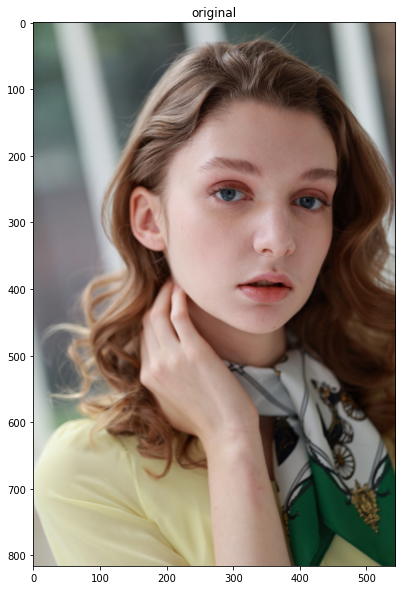

In [19]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.title('original')
plt.imshow(img)

In [20]:
print(trimap.shape)
print(img.shape)

(816, 544)
(816, 544, 3)


In [21]:
# create matte
!python /content/indexnet_matting_sample/scripts/demo2.py ./examples/images/image01.png ./examples/trimaps/trimap.png

./examples/images/image01.png
./examples/trimaps/trimap.png
framerate: 45.36Hz


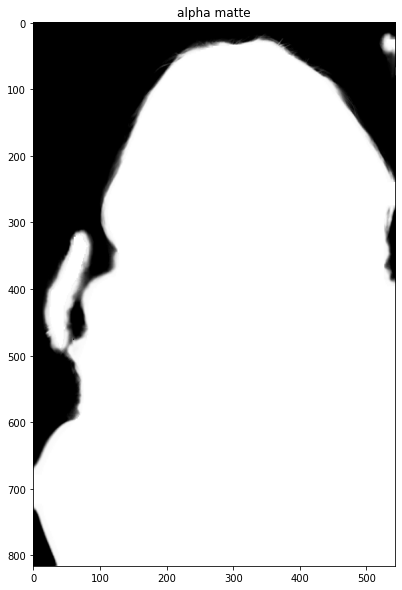

In [22]:
matte = cv2.imread("/content/indexnet_matting_sample/examples/mattes/image01.png")
matte = cv2.cvtColor(matte, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.title('alpha matte')
plt.imshow(matte)

h,w,_ = img.shape
bg = np.full_like(img,255) 

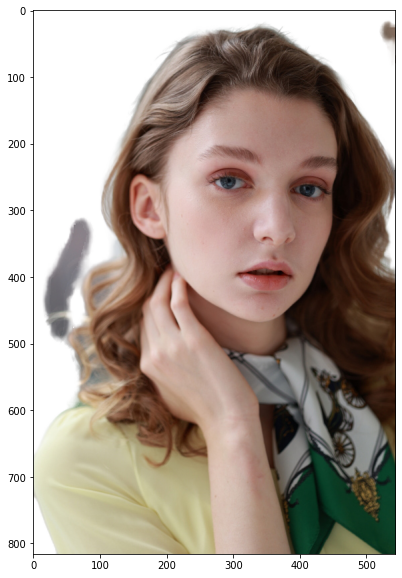

In [23]:
img = img.astype(float)
bg = bg.astype(float)

matte = matte.astype(float)/255
img = cv2.multiply(img, matte)
bg = cv2.multiply(bg, 1.0 - matte)
outImage = cv2.add(img, bg)

plt.figure(figsize=(10,10))
plt.imshow(outImage/255)

#detectron2でtrimapを作成

 ## install detectron2

In [24]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 15.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=4216445ef51339f69960133862b55d5bb4d1b68efd45f290beb87d6d21e3ad74
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [25]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 668kB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=eb6fe925bfdb3864edf7a7a6a05d319c08499b97dcbea1e95321f8be2ccc316f
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [26]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [57]:
# get InstanceSegmentation config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST= 0.9
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)

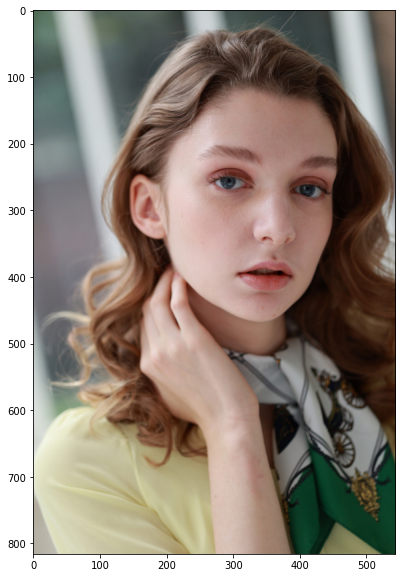

In [58]:
img = cv2.imread('/content/drive/MyDrive/work/canon-rf85mm-f-2-macro-is-stm-portrait-photography_2063-02.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img)

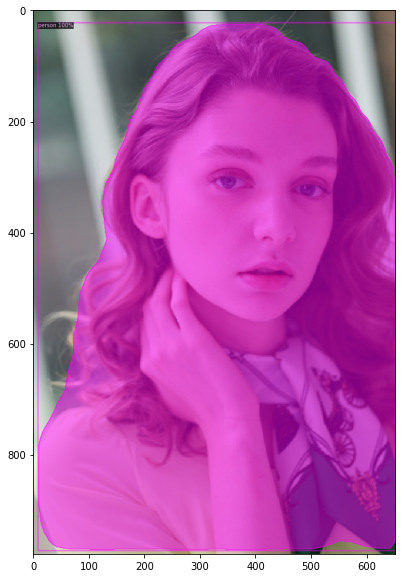

In [59]:
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

v = Visualizer(img, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#cv2_imshow(v.get_image()[:, :, ::-1])

plt.figure(figsize=(10,10))
plt.imshow(v.get_image())

In [60]:
# 出力結果のクラスを確認
pred_classes = outputs['instances'].pred_classes.cpu().tolist()
class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
pred_class_names = list(map(lambda x: class_names[x], pred_classes))

print(pred_class_names)

['person']


In [61]:
# 人物を検出したかチェック
idxs = [i for i, x in enumerate(pred_class_names) if x=="person"]

# 人物の検出あり？
if len(idxs) > 0:
  print(f"score0.9以上の人物検出数：{len(idxs)}")
else:
  print("人物なし")

score0.9以上の人物検出数：1


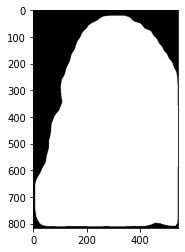

In [62]:
# maskを確認
mask = outputs['instances'][0].pred_masks.byte().cpu().numpy()

n, h, w = mask.shape
mask = mask.reshape(h,w)

plt.imshow(mask)

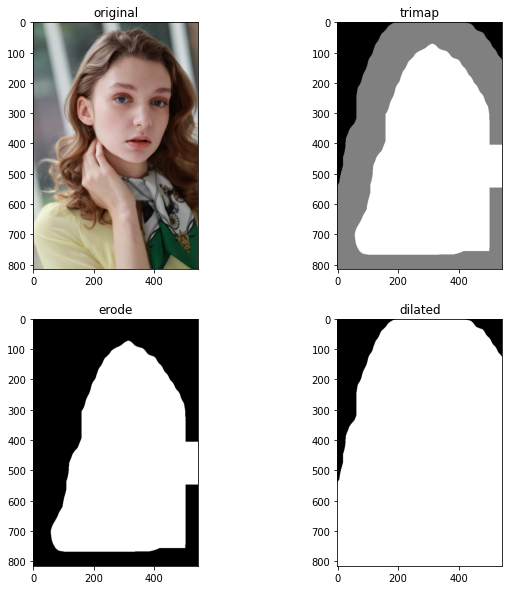

In [63]:
# マスク画像をerodeとdilateしてtrimapを作成
def gen_trimap(mask,k_size_e, k_size_d, ite_e,ite_d):
    kernel_e = np.ones(k_size_e,np.uint8)
    kernel_d = np.ones(k_size_d,np.uint8)
    eroded = cv2.erode(mask,kernel_e,iterations = ite_e)
    dilated = cv2.dilate(mask,kernel_d,iterations = ite_d)
    trimap = np.full((h,w), 128,  dtype=np.uint8)
    trimap[eroded == 255] = 255
    trimap[dilated == 0] = 0
    return trimap, eroded, dilated

np.place(mask, mask >0 , 255)
trimap, eroded, dilated = gen_trimap(mask,k_size_e=(10,10),k_size_d=(5,5), ite_e=10,  ite_d=20)
cv2.imwrite('/content/indexnet_matting_sample/examples/trimaps/trimap_detectron.png',trimap)
#plt.gray()
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title('original')
plt.imshow(img)

plt.subplot(2,2,2)
plt.title('trimap')
plt.imshow(trimap, vmin = 0, vmax = 255)

plt.subplot(2,2,3)
plt.title('erode')
plt.imshow(eroded)

plt.subplot(2,2,4)
plt.title('dilated')
plt.imshow(dilated)

In [64]:
# create matte
!python /content/indexnet_matting_sample/scripts/demo2.py ./examples/images/image01.png ./examples/trimaps/trimap_detectron.png

./examples/images/image01.png
./examples/trimaps/trimap_detectron.png
framerate: 42.68Hz


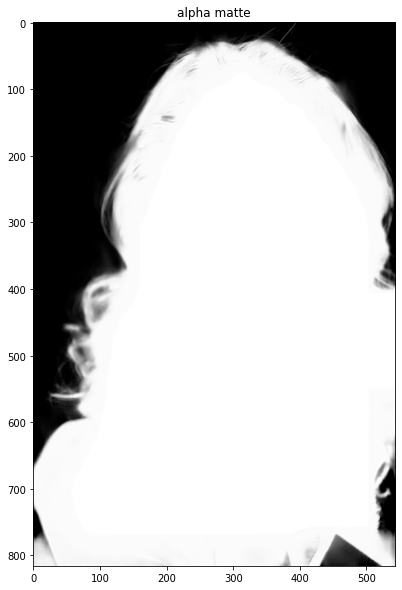

In [65]:
matte = cv2.imread("/content/indexnet_matting_sample/examples/mattes/image01.png")
matte = cv2.cvtColor(matte, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.title("alpha matte")
plt.imshow(matte)

h,w,_ = img.shape
bg = np.full_like(img,255) 

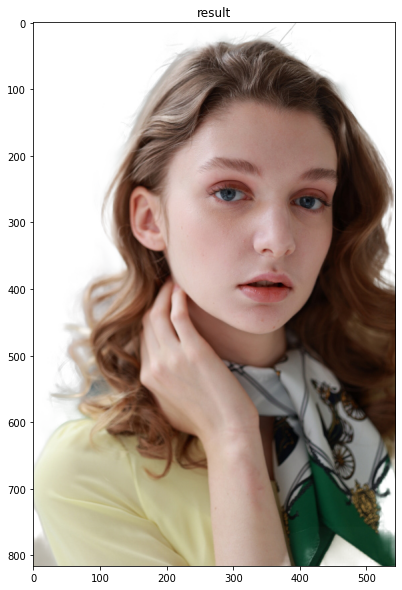

In [66]:
img = img.astype(float)
bg = bg.astype(float)

matte = matte.astype(float)/255
img = cv2.multiply(img, matte)
bg = cv2.multiply(bg, 1.0 - matte)
outImage = cv2.add(img, bg)

plt.figure(figsize=(10,10))
plt.title("result")
plt.imshow(outImage/255)

##Panoptic Segmentation
 

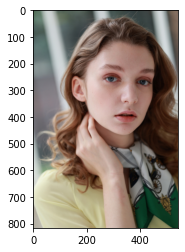

In [37]:
img = cv2.imread('/content/indexnet_matting_sample/examples/images/image01.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

model_final_cafdb1.pkl: 261MB [00:57, 4.53MB/s]                           


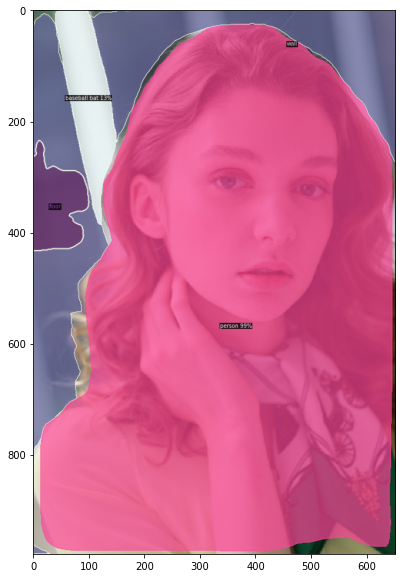

In [38]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(img)["panoptic_seg"]

v = Visualizer(img, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
# cv2_imshow(v.get_image()[:, :, ::-1])
plt.figure(figsize=(10,10))
plt.imshow(v.get_image())

In [39]:
panoptic_seg
mask = panoptic_seg.byte().cpu().numpy()
mask
mask2 = mask.copy()
panoptic_seg

tensor([[0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        ...,
        [4, 4, 4,  ..., 0, 0, 0],
        [4, 4, 4,  ..., 0, 0, 0],
        [4, 4, 4,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32)

In [40]:
np.unique(mask)

array([0, 1, 2, 3, 4], dtype=uint8)

In [41]:
# 出力結果のクラスを確認
pred_classes = [ct['category_id'] for ct in segments_info]
class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
pred_class_names = list(map(lambda x: class_names[x], pred_classes))

print(pred_class_names)

['person', 'baseball bat', 'knife', 'hot dog']


In [42]:
pserson_seg_num = segments_info[0]['instance_id']
np.place(mask, mask>1  , 100)
np.place(mask, mask==1 , 255)
np.place(mask, mask==0 , 255)
np.place(mask, mask==100 , 0)

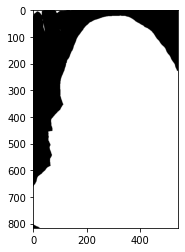

In [43]:
plt.imshow(mask)

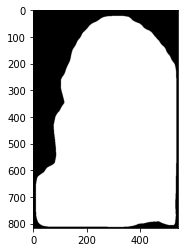

In [44]:
np.place(mask2, mask2>1, 0)
np.place(mask2, mask2==1, 255)
plt.imshow(mask2)

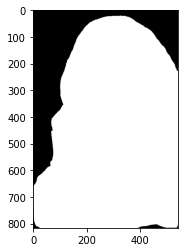

In [45]:
# マスク画像をerodeとdilateしてtrimapを作成
kernel_d = np.ones((3,3),np.uint8)
dilated = cv2.dilate(mask2,kernel_d,iterations = 10)
trimap = mask
trimap[dilated == 0] = 0

plt.imshow(trimap)

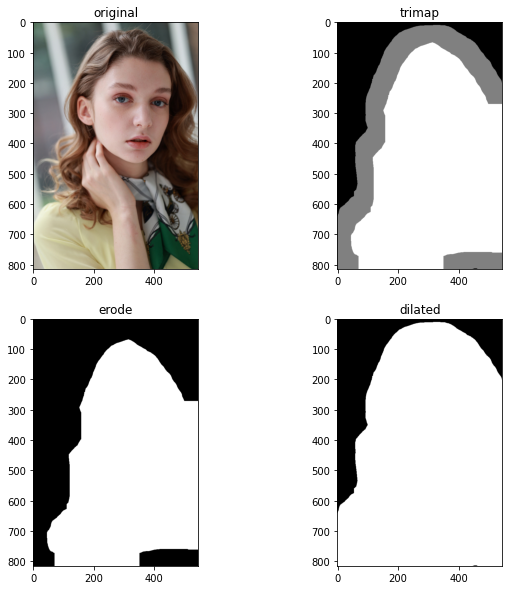

In [46]:
# マスク画像をerodeとdilateしてtrimapを作成
def gen_trimap(mask,k_size_e, k_size_d, ite_e,ite_d):
    kernel_e = np.ones(k_size_e,np.uint8)
    kernel_d = np.ones(k_size_d,np.uint8)
    eroded = cv2.erode(mask,kernel_e,iterations = ite_e)
    dilated = cv2.dilate(mask,kernel_d,iterations = ite_d)
    trimap = np.full((h,w), 128,  dtype=np.uint8)
    trimap[eroded == 255] = 255
    trimap[dilated == 0] = 0
    return trimap, eroded, dilated

# np.place(mask, mask >0 , 255)
trimap, eroded, dilated = gen_trimap(trimap,k_size_e=(30,30),k_size_d=(10,10), ite_e=3,  ite_d=2)
cv2.imwrite('/content/indexnet_matting_sample/examples/trimaps/trimap_detectron.png',trimap)
#plt.gray()
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title('original')
plt.imshow(img)

plt.subplot(2,2,2)
plt.title('trimap')
plt.imshow(trimap, vmin = 0, vmax = 255)

plt.subplot(2,2,3)
plt.title('erode')
plt.imshow(eroded)

plt.subplot(2,2,4)
plt.title('dilated')
plt.imshow(dilated)

In [47]:
cv2.imwrite('/content/indexnet_matting_sample/examples/trimaps/trimap_detectron.png',trimap)

True

In [48]:
# create matte
!python /content/indexnet_matting_sample/scripts/demo2.py ./examples/images/image01.png ./examples/trimaps/trimap_detectron.png

./examples/images/image01.png
./examples/trimaps/trimap_detectron.png
framerate: 45.19Hz


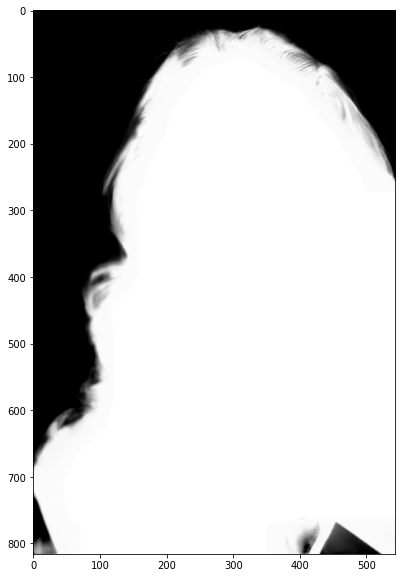

In [49]:
matte = cv2.imread("/content/indexnet_matting_sample/examples/mattes/image01.png")
matte = cv2.cvtColor(matte, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(matte)

h,w,_ = img.shape
bg = np.full_like(img,255) 

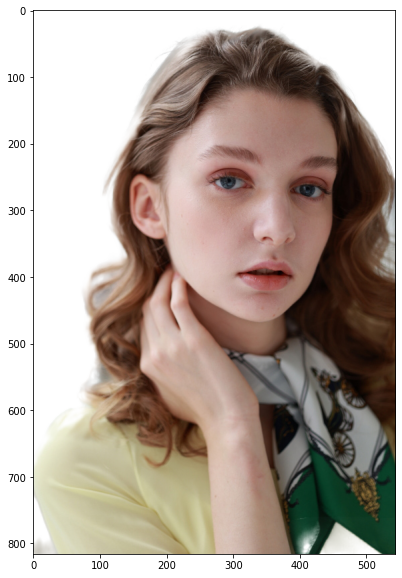

In [50]:
img = img.astype(float)
bg = bg.astype(float)

matte = matte.astype(float)/255
img = cv2.multiply(img, matte)
bg = cv2.multiply(bg, 1.0 - matte)
outImage = cv2.add(img, bg)

plt.figure(figsize=(10,10))
plt.imshow(outImage/255)